In [49]:
import pandas as pd
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [58]:
# Import the data
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
# train_data_gs, test_data_gs = (
#     tf.image.rgb_to_grayscale(train_data).numpy(),
#     tf.image.rgb_to_grayscale(test_data).numpy()
# )

Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


In [59]:
from utils.dataset import get_data_masks
from config import CLASSIFIER_PATH
import numpy as np

# load the model
classifier = tf.keras.models.load_model(f'../{CLASSIFIER_PATH}')

# load the predictions
predictions = np.loadtxt('../in/predictions.csv')
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))

# get the masks for the data
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5, verbose=True)


Found 892/10000 instances for the label 5
Found 167/892 instances for misclassified 5
        


In [60]:
base_dir = '../out/compare_techniques'

# Compute the clusters with different techniques

In [ ]:
from xplique.attributions import GradCAMPP, SmoothGrad, IntegratedGradients, Rise, KernelShap, Lime
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from utils.cluster.ClusteringMode import LocalLatentMode
from utils.cluster.compare import compare_approaches

batch_size=64
explainers = [
        GradCAMPP(classifier),
        SmoothGrad(classifier, nb_samples=50, noise=.3, batch_size=batch_size),
        IntegratedGradients(classifier, steps=50, batch_size=batch_size),
        Rise(classifier, nb_samples=4000, batch_size=batch_size),
        KernelShap(classifier, nb_samples=1000),
        Lime(classifier, nb_samples=1000)
    ]

approaches = [
    LocalLatentMode(
        mask=mask_label,
        explainer=explainer,
        dim_red_techs=[TSNE(perplexity=7)],
        clus_tech=AffinityPropagation()
    )
    for explainer in explainers
]

df = compare_approaches(approaches=approaches, data=test_data, predictions=predictions_cat, iterations=1, verbose=True)


APPROACH: LocalLatentMode
EXPLAINER: GradCAMPP
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 7, 'random_state': None, 'square_distances': 'legacy', 'verbose': 0}]
            
1/1 -> 0.4060077965259552

APPROACH: LocalLatentMode
EXPLAINER: SmoothGrad
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 7, 'random_state': None, 'square_distances': 'legacy', 'verbose': 0}]
            
1/1 -> 0.46576741337776184

APPROACH: LocalLatentMode
E

In [64]:
df

,CLUSTERING_MODE,EXPLAINER,CLUSTERING_TECHNIQUE,DIMENSIONALITY_REDUCTION_TECHNIQUE,DIMENSIONALITY_REDUCTION_TECHNIQUE_PARAMS,SILHOUETTE,CLUSTERS,TIME_CONTRIBUTIONS,TIME_CLUSTERING,TIMESTAMP
0,LocalLatentMode,GradCAMPP,AffinityPropagation,[TSNE],"[{'angle': 0.5, 'early_exaggeration': 12.0, 'i...",0.406,<clusim.clustering.Clustering object at 0x1b3d...,1.32239,2.81203,2022-04-13 12:04:08.973645
1,LocalLatentMode,SmoothGrad,AffinityPropagation,[TSNE],"[{'angle': 0.5, 'early_exaggeration': 12.0, 'i...",0.466,<clusim.clustering.Clustering object at 0x1b3d...,49.59021,2.89132,2022-04-13 12:05:01.457989
2,LocalLatentMode,IntegratedGradients,AffinityPropagation,[TSNE],"[{'angle': 0.5, 'early_exaggeration': 12.0, 'i...",0.409,<clusim.clustering.Clustering object at 0x1b3d...,49.19999,3.14964,2022-04-13 12:05:53.810063
3,LocalLatentMode,Rise,AffinityPropagation,[TSNE],"[{'angle': 0.5, 'early_exaggeration': 12.0, 'i...",0.519,<clusim.clustering.Clustering object at 0x1b3d...,1152.07998,3.32915,2022-04-13 12:25:09.221678
4,LocalLatentMode,KernelShap,AffinityPropagation,[TSNE],"[{'angle': 0.5, 'early_exaggeration': 12.0, 'i...",0.450,<clusim.clustering.Clustering object at 0x1b3d...,849.23698,2.59789,2022-04-13 12:39:21.064061
5,LocalLatentMode,Lime,AffinityPropagation,[TSNE],"[{'angle': 0.5, 'early_exaggeration': 12.0, 'i...",0.455,<clusim.clustering.Clustering object at 0x1b3d...,247.43491,3.09960,2022-04-13 12:43:31.601564


In [65]:
from utils.cluster.preprocessing import distance_matrix

# create the dataframe with the pairwise distances between the resulting clusters
dist_df = pd.DataFrame(distance_matrix(df['CLUSTERS'].values, lambda lhs, rhs: 1 - intra_pairs_similarity(lhs, rhs)), columns=df['EXPLAINER'], index=df['EXPLAINER'])
# compute the average over the same technique
dist_df = dist_df.groupby(dist_df.columns, axis=1).mean()
dist_df = dist_df.groupby(dist_df.index, axis=0).mean()
# np.fill_diagonal(dist_df.values, 0)
dist_df

EXPLAINER,GradCAMPP,IntegratedGradients,KernelShap,Lime,Rise,SmoothGrad
EXPLAINER,,,,,,
GradCAMPP,0.000000,0.847270,0.890156,0.885095,0.871997,0.777307
IntegratedGradients,0.847270,0.000000,0.810645,0.816322,0.904524,0.703833
KernelShap,0.890156,0.810645,0.000000,0.389194,0.921854,0.825204
Lime,0.885095,0.816322,0.389194,0.000000,0.922025,0.826062
Rise,0.871997,0.904524,0.921854,0.922025,0.000000,0.847989
SmoothGrad,0.777307,0.703833,0.825204,0.826062,0.847989,0.000000


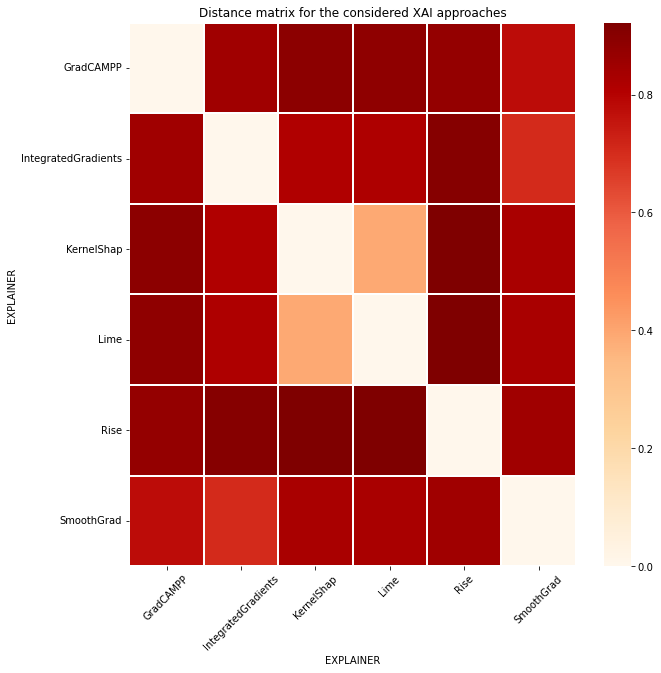

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.general import save_figure

# plot it with seaborn
fig = plt.figure(figsize=(10,10))
sns.heatmap(
    dist_df,
    cmap='OrRd',
    linewidth=.1
).set_title('Distance matrix for the considered XAI approaches')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
save_figure(fig, f'../out/distance_matrix/xai_techniques')

# Import the feature-maps clusters

In [67]:
import os

import numpy as np
from clusim.clustering import Clustering

from config import FEATURE_MAP_CLUSTERS

feature_maps_clusters = [
    {
        'EXPLAINER': file_name.split('.')[0],
        'CLUSTERS': Clustering().from_cluster_list(np.load(os.path.join(FEATURE_MAP_CLUSTERS, file_name), allow_pickle=True))
    }
    for file_name in os.listdir(FEATURE_MAP_CLUSTERS)
]
feature_maps_clusters_df = pd.DataFrame(feature_maps_clusters)
feature_maps_clusters_df

,EXPLAINER,CLUSTERS
0,moves + orientation,<clusim.clustering.Clustering object at 0x1af5...
1,orientation + bitmaps,<clusim.clustering.Clustering object at 0x1af4...
2,moves + bitmaps,<clusim.clustering.Clustering object at 0x1af4...


In [68]:
complete_df = pd.concat([df[['EXPLAINER', 'CLUSTERS']], feature_maps_clusters_df])
complete_df = complete_df.sort_values(by=['EXPLAINER'])
complete_df.head()

,EXPLAINER,CLUSTERS
0,GradCAMPP,<clusim.clustering.Clustering object at 0x1b3d...
2,IntegratedGradients,<clusim.clustering.Clustering object at 0x1b3d...
4,KernelShap,<clusim.clustering.Clustering object at 0x1b3d...
5,Lime,<clusim.clustering.Clustering object at 0x1b3d...
3,Rise,<clusim.clustering.Clustering object at 0x1b3d...


In [69]:
from utils.cluster.preprocessing import distance_matrix
from utils.cluster.similarity_metrics import intra_pairs_similarity

# create the dataframe with the pairwise distances between the resulting clusters
complete_dist_df = pd.DataFrame(
    distance_matrix(complete_df['CLUSTERS'].values, lambda lhs, rhs: 1 - intra_pairs_similarity(lhs, rhs)),
    columns=complete_df['EXPLAINER'],
    index=complete_df['EXPLAINER']
)
# compute the average over the same technique
complete_dist_df = complete_dist_df.groupby(complete_dist_df.columns, axis=1).mean()
complete_df = complete_dist_df.groupby(complete_dist_df.index, axis=0).mean()
# np.fill_diagonal(dist_df.values, 0)
complete_dist_df

EXPLAINER,GradCAMPP,IntegratedGradients,KernelShap,Lime,Rise,SmoothGrad,moves + bitmaps,moves + orientation,orientation + bitmaps
EXPLAINER,,,,,,,,,
GradCAMPP,0.000000,0.847270,0.890156,0.885095,0.871997,0.777307,0.928619,0.910902,0.970539
IntegratedGradients,0.847270,0.000000,0.810645,0.816322,0.904524,0.703833,0.936428,0.907769,0.972116
KernelShap,0.890156,0.810645,0.000000,0.389194,0.921854,0.825204,0.941856,0.915093,0.980720
Lime,0.885095,0.816322,0.389194,0.000000,0.922025,0.826062,0.941752,0.916893,0.980103
Rise,0.871997,0.904524,0.921854,0.922025,0.000000,0.847989,0.936200,0.942374,0.981834
SmoothGrad,0.777307,0.703833,0.825204,0.826062,0.847989,0.000000,0.934946,0.931435,0.978731
moves + bitmaps,0.928619,0.936428,0.941856,0.941752,0.936200,0.934946,0.000000,0.920732,0.861701
moves + orientation,0.910902,0.907769,0.915093,0.916893,0.942374,0.931435,0.920732,0.000000,0.850388
orientation + bitmaps,0.970539,0.972116,0.980720,0.980103,0.981834,0.978731,0.861701,0.850388,0.000000


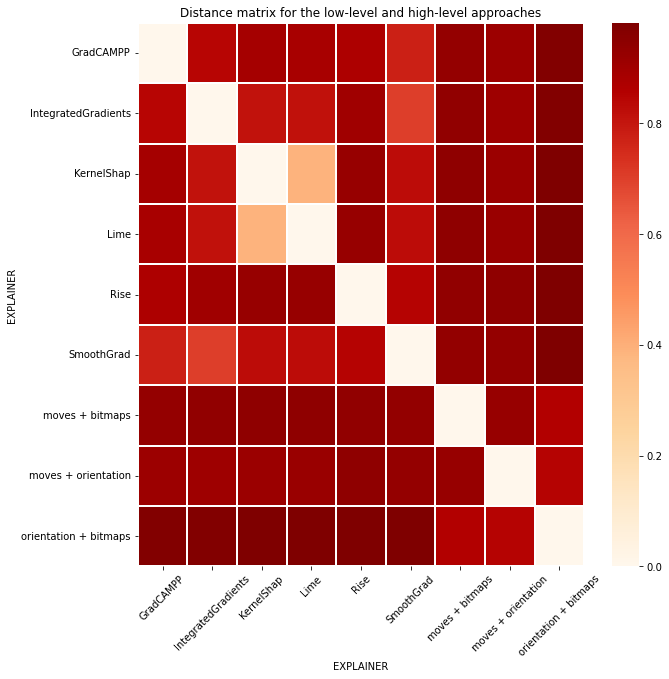

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.general import save_figure

# plot it with seaborn
fig = plt.figure(figsize=(10, 10))
sns.heatmap(
    complete_dist_df,
    cmap='OrRd',
    linewidth=.1
).set_title('Distance matrix for the low-level and high-level approaches')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
save_figure(fig, f'../out/distance_matrix/low-level_and_high-level')